# Logistic Regression and Support Vector Machine

To predict whether a face image is male or female using logistic regression model, support vector machine, naive bayes, and KNN.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)

C:\Users\Sean\AppData\Local\Temp/ipykernel_29476/1552743865.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("svg")


## 1. Loading Data and Pre-processing
We first need to load the images.  Download `photos-bw.zip` and put it in the same directory as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
imgdata = []
genders = []

# load the zip file
filename = 'photos-bw.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "photos-bw/*.png"):
        print("loading", name)
        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        myfile.close()
        
        # append to data
        imgdata.append(img)
        genders.append( int(name[len("photos-bw/")] == 'm') )  # 0 is female, 1 is male
        
zfile.close()
imgsize = img.shape
print("DONE: loaded {} images".format(len(imgdata)))

loading photos-bw/f-039-01.png
loading photos-bw/f-040-01.png
loading photos-bw/f-041-01.png
loading photos-bw/f-042-01.png
loading photos-bw/f-043-01.png
loading photos-bw/f1-001-0.png
loading photos-bw/f1-002-0.png
loading photos-bw/f1-003-0.png
loading photos-bw/f1-004-0.png
loading photos-bw/f1-005-0.png
loading photos-bw/f1-006-0.png
loading photos-bw/f1-007-0.png
loading photos-bw/f1-008-0.png
loading photos-bw/f1-009-0.png
loading photos-bw/f1-010-0.png
loading photos-bw/f1-011-0.png
loading photos-bw/f1-012-0.png
loading photos-bw/f1-013-0.png
loading photos-bw/f1-014-0.png
loading photos-bw/f1-015-0.png
loading photos-bw/m-063-01.png
loading photos-bw/m-064-01.png
loading photos-bw/m-065-01.png
loading photos-bw/m-067-01.png
loading photos-bw/m-069-01.png
loading photos-bw/m-070-01.png
loading photos-bw/m-073-01.png
loading photos-bw/m-074-01.png
loading photos-bw/m-075-01.png
loading photos-bw/m-077-01.png
loading photos-bw/m-083-01.png
loading photos-bw/m-085-01.png
loading 

Each image is a 45x40 array of pixel values.  Run the below code to show an example:

(45, 40)


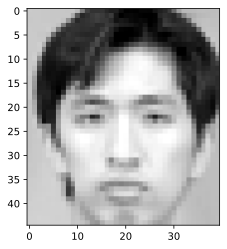

In [3]:
print(img.shape)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

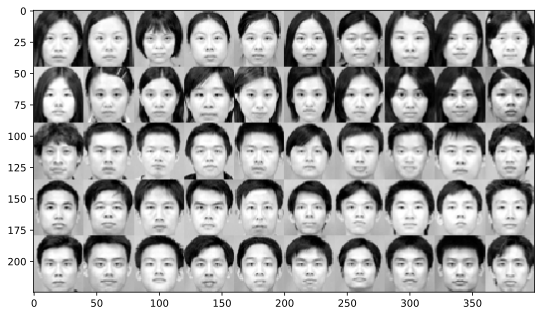

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
X = empty((50, prod(imgdata[0].shape))) # create empty array
for i,img in enumerate(imgdata):
    X[i,:] = ravel(img)           # for each image, turn it into a vector
Y = asarray(genders)  # convert list to numpy array
print(X.shape)
print(Y.shape)

(50, 1800)
(50,)


Next we will shift the pixel values so that gray is 0.0, black is -0.5 and white is 0.5.

In [6]:
print("Before: min={}, max={}".format(X.min(), X.max()))
X -= 0.5
print("After:  min={}, max={}".format(X.min(), X.max()))

Before: min=0.0, max=1.0
After:  min=-0.5, max=0.5


Finally, split the dataset into a training set and testing set. We select 80% for training and 20% for testing.

In [7]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(40, 1800)
(10, 1800)


## 2. Logistic Regression
Train a logistic regression classifier.  Use cross-validation to select the best $C$ parameter.

In [9]:
logreg = linear_model.LogisticRegressionCV(Cs=10, cv=10)
logreg.fit(trainX, trainY)
print(logreg.C_)

[0.04641589]


Use the learned model to predict the genders for the training and testing data. What is the accuracy on the training set? What is the accuracy on the testing set?

In [10]:
predYtrain, predYtest = logreg.predict(trainX), logreg.predict(testX)
train_acc = metrics.accuracy_score(trainY, predYtrain)
test_acc = metrics.accuracy_score(testY, predYtest)

print("training accuracy is: {:.2f}".format(train_acc))
print("test accuracy is: {:.2f}".format(test_acc))

training accuracy is: 0.95
test accuracy is: 0.80


### 2.1 Analyzing the classifier
Run the below code to show the hyperplane parameter $\mathbf{w}$ as an image.  

In [11]:
# logreg is the learned logistic regression model
wimg = logreg.coef_.reshape(imgsize)      # get the w and reshape into an image
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("weight image")
plt.show()

Recall that the classifier prediction is based on the sign of the function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b = \sum_{i=1}^P w_ix_i + b$.  Here each $x_i$ is a pixel in the face image, and $w_i$ is the corresponding weight.  Hence, the function is multiplying face image by the weight image, and then summing over all pixels.

In order for $f(\mathbf{x})$ to be positive, then the positive values of the weight image (red regions) should match the positive values in the face image (white pixels), and the negative values of the weight image (blue regions) should be matched with negative values in the face image (black pixels).

Hence, we can have the following interpretation:
<table>
<tr><th>Class</th><th>red regions (positive weights)</th><th>blue regions (negative weights)</th><th>white regions (weights near 0)</th></tr>
<tr><td>+1 class (male)</td><td>white pixels in face image</td><td>black pixels in face image</td><td>region not important</td></tr>
<tr><td>-1 class (female)</td><td>black pixels in face image</td><td>white pixels in face image</td><td>region not important</td></tr>
</table>
  
_Looking at the weight image, what parts of the face image is the classifier looking at to determine the gender?  Does it make sense?_

1. The red region may correspond to the hair. Usually females tend to have longer hair than males. So this quite makes sense when distinguishing gender.
2. There are two blue regions. One blue region may be the haid above the forehead. Maybe this is because males tend to have this hairstyle while females do not. Another blue region (smaller) may correspond to the nose tip and the eye brow. This may be due to that males tend to have wider nose tips and thicker eye brows.

Now let's look at the misclassified faces in the test set.  Run the below code to show the misclassifed and correctly classified faces.

In [11]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

_Why did the classifier make incorrect predictions on the misclassified faces?_
    
    Their long hair didn't show up in the image, which is a key to distinguish female and male as far as the trained model is concerned.

## 3. Support Vector Machine
Now train a support vector machine (SVM) on the same training and testing data.  Use cross-validation to select the best $C$ parameter.

In [12]:
### INSERT YOUR CODE HERE
## HINT 
# 1. C: paramgrid = {'C': logspace(-4,4,20)}
# 2. cross-validation: model_selection.GridSearchCV()
# 3. SVM: svm.SVC()

paragrid = {'C':logspace(-4, 4, 20)}
gridsearch = model_selection.GridSearchCV(svm.SVC(kernel='linear'), param_grid=paragrid, cv=10)

gridsearch.fit(trainX, trainY)
print(gridsearch.best_params_['C'])

0.012742749857031334


Calculate the training and test accuracy for the SVM classifier.

In [13]:
### INSERT YOUR CODE HERE
## HINT
# 1. To calculate the accuracy: metrics.accuracy_score(label, pred)

predYtrain, predYtest = gridsearch.predict(trainX), gridsearch.predict(testX)
train_acc = metrics.accuracy_score(trainY, predYtrain)
test_acc = metrics.accuracy_score(testY, predYtest)

print("training accuracy is: {:.2f}".format(train_acc))
print("test accuracy is: {:.2f}".format(test_acc))

training accuracy is: 0.95
test accuracy is: 0.80


Similar to before, plot an image of the hyperplane parameters $w$, and view the misclassified and correctly classified test images.

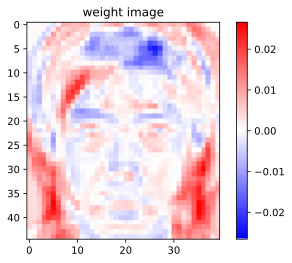

In [14]:
### INSERT YOUR CODE HERE

wimg = gridsearch.best_estimator_.coef_.reshape(imgsize)      # get the w and reshape into an image
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("weight image")
plt.show()

Now let's also look at the misclassified faces in the test set. To show the misclassifed and correctly classified faces like above.

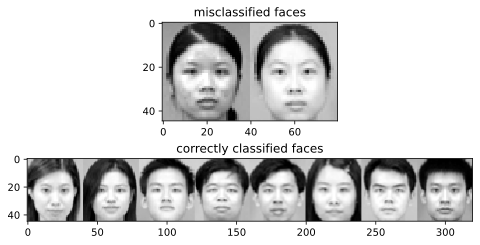

In [15]:
# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
        
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

_Are there any differences between the $w$ for logistic regressiona and the $w$ for SVM?  Is there any interpretation for the differences?_

    There aren't any major differences. But the SVM weight image seems to be more detailed. There are less white regions on the face in the weight image, which means many irrelevant pixels identified by the logistic regression method were taken into account by SVM.

## 4. Naive Bayes
Next, we train a naive bayes (NB), which is delieved at last lecture, on the same training and testing data. Then, showing the accuracy of training and testing set.

In [12]:
### INSERT YOUR CODE HERE
## HINT
# 1. naive_bayes.GaussianNB()
# 2. metrics.accuracy_score()

bayes = naive_bayes.GaussianNB()
bayes.fit(trainX, trainY)

predYtrain, predYtest = bayes.predict(trainX), bayes.predict(testX)
train_acc = metrics.accuracy_score(trainY, predYtrain)
test_acc = metrics.accuracy_score(testY, predYtest)

print("training accuracy is: {:.3f}".format(train_acc))
print("test accuracy is: {:.2f}".format(test_acc))

training accuracy is: 0.975
test accuracy is: 0.90


Now let's also look at the misclassified faces in the test set. To show the misclassifed and correctly classified faces like above.

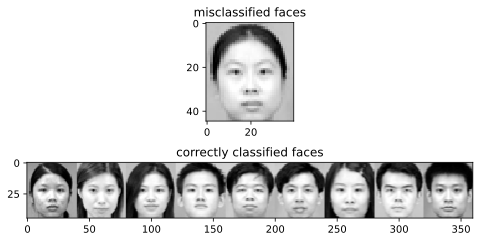

In [13]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

## 5. K Nearest Neighbor
In addition, to train a K Nearest Neighbor (KNN) model, which is delieved at last lecture, on the same training and testing data. Using cross-validation to select the best  K  parameter. Then, showing the accuracy of training and testing set.

In [14]:
paragrid = {'n_neighbors':[3,5,10]}
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), paragrid, n_jobs=-1, cv=10)

In [15]:
clf.fit(trainX, trainY)
# predict from the model
predYtrain = clf.predict(trainX)
predYtest = clf.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(trainY, predYtrain)
print("train accuracy =", acc)

# calculate accuracy
acc = metrics.accuracy_score(testY, predYtest)
print("test accuracy  =", acc)

train accuracy = 0.875
test accuracy  = 0.8


Now let's also look at the misclassified faces in the test set. To show the misclassifed and correctly classified faces like above.

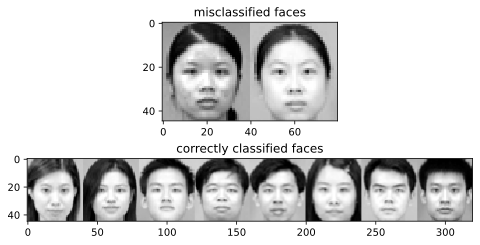

In [16]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predYtest != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predYtest == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()